# National trends in peak annual streamflow

## Introduction

This notebook demonstrates a slightly more advanced application of data_retrieval.nwis to collect  using a national dataset of historical peak annual streamflow measurements. The objective is to use a regression of peak annual streamflow and time to identify any trends. But, not for a singile station,

## Setup
Before we begin any analysis, we'll need to setup our environment by importing any modules.

In [3]:
from scipy import stats
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt

from data_retrieval import nwis, utils, codes

## Basic usage
Recall that the basic way to download data from NWIS is through through the `nwis.get_record()` function, which returns a user-specified record as a `pandas` dataframe. The `nwis.get_record()` function is really a facade of sorts, that allows the user to download data from various NWIS services through a consistant interface. To get started, we require a few simple parameters: a list of site numbers or states codes, a service, and a start date.

In [62]:
# download annual peaks from a single site
df = nwis.get_record(sites='03339000', service='peaks', start='1970-01-01')
df.head()

# alternatively information for the entire state of illiois can be downloaded using
#df = nwis.get_record(state_cd='il', service='peaks', start='1970-01-01')

,agency_cd,site_no,peak_tm,peak_va,peak_cd,gage_ht,gage_ht_cd,year_last_pk,ag_dt,ag_tm,ag_gage_ht,ag_gage_ht_cd
datetime,,,,,,,,,,,,
1970-04-20,USGS,03339000,NaN,16300,5,19.80,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-05,USGS,03339000,NaN,8910,5,13.61,NaN,NaN,NaN,NaN,NaN,NaN
1972-04-22,USGS,03339000,NaN,9240,5,13.94,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-23,USGS,03339000,NaN,16600,5,20.00,NaN,NaN,NaN,NaN,NaN,NaN
1974-06-23,USGS,03339000,NaN,19500,5,21.70,NaN,NaN,NaN,NaN,NaN,NaN


Most of the fields are empty, but no matter. All we require are date (`datetime`), site number (`site_no`), and peak streamflow (`peak_va`).

Note that when multiple sites are specified, `nwis.get_record()` will combine `datetime` and `site_no` fields to create a multi-index dataframe.

## Preparing the regression
Next we'll define a function that applies ordinary least squares on peak discharge and time.
After grouping the dataset by `site_no`, we will apply the regression on a per-site basis. The results from each site, will be returned as a row that includes the slope, y-intercept, r$^2$, p value, and standard error of the regression.

In [7]:
def peak_trend_regression(df):
    """
    """
    #convert datetimes to days for regression
    peak_date = df.index
    peak_date = pd.to_datetime(df.index.get_level_values(1))
    df['peak_d'] = (peak_date - peak_date.min()) / np.timedelta64(1,'D')
    #df['peak_d'] = (df['peak_dt'] - df['peak_dt'].min())  / np.timedelta64(1,'D')
    
    #normalize the peak discharge values
    df['peak_va'] = (df['peak_va'] - df['peak_va'].mean())/df['peak_va'].std()
    
    slope, intercept, r_value, p_value, std_error = stats.linregress(df['peak_d'], df['peak_va'])
    
    #df_out = pd.DataFrame({'slope':slope,'intercept':intercept,'p_value':p_value},index=df['site_no'].iloc[0])
    
    #return df_out
    return pd.Series({'slope':slope,'intercept':intercept,'p_value': p_value,'std_error':std_error})

## Preparing the analysis

In [8]:
def peak_trend_analysis(states, start_date):
    """
    states : list
        a list containing the two-letter codes for each state to include in the 
        analysis.
    
    start_date : string
        the date to use a the beginning of the analysis.
    """
    final_df = pd.DataFrame()

    for state in states:
        # download annual peak discharge records
        df = nwis.get_record(state_cd=state, start=start_date, service='peaks')
        # group the data by site and apply our regression
        temp = df.groupby('site_no').apply(peak_trend_regression).dropna()
        # drop any insignificant results
        temp = temp[temp['p_value']<0.05]
        
        # now download metadata for each site, which we'll use later to plot the sites
        # on a map
        site_df = nwis.get_record(sites=temp.index, service='site')
        
        if final_df.empty:
            final_df = pd.merge(site_df, temp, right_index=True, left_on='site_no')
            
        else:
            final_df = final_df.append( pd.merge(site_df, temp, right_index=True, left_on='site_no') )
            
    return final_df
  


To run the analysis for all states since 1970, one would only need to uncomment and run the following lines. However, pulling all that data from NWIS takes time and puts and could put a burden on resoures.

In [11]:
# Warning these lines will download a large dataset from the web and
# will take few minutes to run.

#start = '1970-01-01'
#states = codes.state_codes
#final_df = peak_trend_analysis(states=states, start_date=start)
#final_df.to_csv('datasets/peak_discharge_trends.csv')

Instead, lets quickly load some predownloaded data, which I generated using the code above.

In [13]:
final_df = pd.read_csv('datasets/peak_discharge_trends.csv')
final_df.head()

,Unnamed: 0,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,intercept,p_value,slope,std_error
0,0,USGS,2343275,ABBIE CREEK NEAR ABBEVILLE AL,ST,31.561836,-85.204932,U,NAD83,NaN,NaN,NaN,3130004.0,-0.641911,0.015899,0.000231,0.000065
1,1,USGS,2360275,JUDY CREEK NEAR OZARK AL,ST,31.463224,-85.572159,U,NAD83,NaN,NaN,NaN,3140201.0,-0.702569,0.004652,0.000269,0.000069
2,2,USGS,2360500,EAST FORK CHOCTAWHATCHEE R NEAR MIDLAND CITY AL,ST,31.373227,-85.477158,U,NAD83,179.1,0.01,NGVD29,3140201.0,-1.138552,0.007698,0.000211,0.000003
3,3,USGS,2367400,"YELLOW RIVER NR SANFORD, ALA",ST,31.317391,-86.355788,U,NAD83,NaN,NaN,NaN,3140103.0,-0.611310,0.015836,0.000511,0.000013
4,4,USGS,2367500,LIGHTWOOD KNOT CREEK AT BABBIE AL,ST,31.270725,-86.313564,U,NAD83,185.0,0.01,NGVD29,3140103.0,-0.705676,0.015231,0.000210,0.000052


Notice how the data has been transformed. In addition to statistics about the peak streamflow trends, we've also used the NWIS site service to add latitude and longtitude information for each station.

# Plotting the results
Finally we'll use `basemap` and `matplotlib`, along with the location information from NWIS, to plot the results on a map (shown below). Stations with increasing peak annual discharge are shown in red; whereas, stations with decreasing peaks are blue.

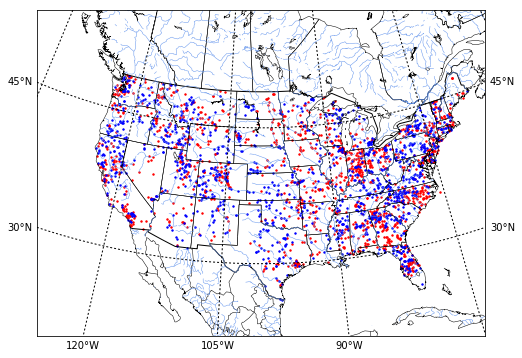

In [63]:
fig = plt.figure(num=None, figsize=(10, 6) )

# setup a basemap covering the contiguous United States
m = Basemap(width=5500000, height=4000000, resolution='l',
            projection='aea', lat_1=36., lat_2=44, lon_0=-100, lat_0=40)


# add coastlines
m.drawcoastlines(linewidth=0.5)

# add parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])

# add boundaries and rivers
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.5, linestyle='solid', color='cornflowerblue')


increasing = final_df[final_df['slope'] > 0]
decreasing = final_df[final_df['slope'] < 0]

#x,y = m(lons, lats)

# categorical plots get a little  ugly in basemap
m.scatter(increasing['dec_long_va'].tolist(), 
          increasing['dec_lat_va'].tolist(), 
          label='increasing', s=2, color='red',
          latlon=True)

m.scatter(decreasing['dec_long_va'].tolist(), 
          decreasing['dec_lat_va'].tolist(), 
          label='increasing', s=2, color='blue',
          latlon=True)